In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
#import pickle
from scipy.spatial import cKDTree
from SCTransform import SCTransform

import warnings
import time
warnings.filterwarnings('ignore')
#export PYTHONWARNINGS='ignore:Multiprocessing-backed parallel loops:UserWarning'
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"



In [2]:

def find_index(sp_genename,sc_genename):
    index_sc=[]
    index_sp=[]
    d={}
    for j in range(len(sc_genename)):
        name=sc_genename[j]
        d[name]=j

    for i in range(len(sp_genename)):
        name=sp_genename[i]
        try:
            d[name]
            flag=1
        except KeyError:
            flag=0
        if flag==1:
            index_sc.append(d[name])
            index_sp.append(i)
    return index_sp,index_sc


In [3]:
scdatapath='./inputSC/'
spdatapath='./inputSP/'

ad_sp_ori=sc.read(spdatapath+'gene_by_cell.csv').transpose()
ad_sc_si=sc.read_h5ad(scdatapath+'input_ref.h5ad') #.transpose()

#ad_sp_ori.var_names_make_unique()
#ad_sc_ori.var_names_make_unique()
coordinate = pd.read_csv(spdatapath+'tissue_positions_list.csv')
coordinate=coordinate.to_numpy()



In [4]:
#make sure it is true (order of cells in count matrix and location matrix is identical) 
np.array_equal(coordinate[:,0],ad_sp_ori.obs_names)

True

In [5]:
print(ad_sp_ori)
print(ad_sc_si)
print(coordinate.shape)

AnnData object with n_obs × n_vars = 7416 × 241
AnnData object with n_obs × n_vars = 2239 × 32287
    obs: 'cluster'
(7416, 4)


In [6]:
#ad_sp_ori.obs['coord_x']=coordinate[:,1].astype(str)
#ad_sp_ori.obs['coord_y']=coordinate[:,2].astype(str)
#ad_sp_ori.obs['coord_z']=coordinate[:,3].astype(str)

In [7]:
sc.pp.filter_cells(ad_sp_ori, min_counts=5)
sc.pp.filter_cells(ad_sc_si, min_counts=5)
print(ad_sp_ori)
print(ad_sc_si)

AnnData object with n_obs × n_vars = 7416 × 241
    obs: 'n_counts'
AnnData object with n_obs × n_vars = 2239 × 32287
    obs: 'cluster', 'n_counts'


In [8]:
Original_counts=ad_sc_si.copy()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


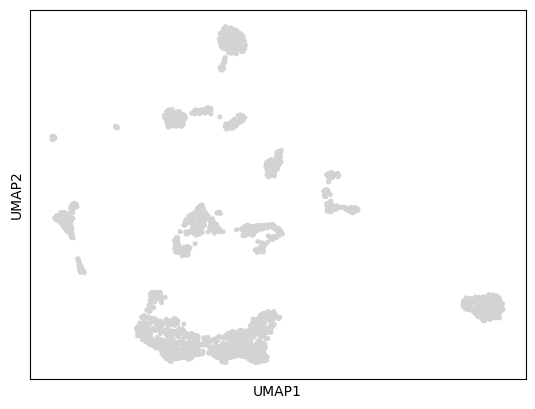

In [9]:
sc.pp.normalize_total(Original_counts)
sc.pp.log1p(Original_counts)
#sc.pp.scale(Original_counts, max_value=10)

sc.tl.pca(Original_counts)
sc.pp.neighbors(Original_counts)
sc.tl.umap(Original_counts)
sc.pl.umap(Original_counts)


In [21]:
Original_counts.write_h5ad(scdatapath+'Original_counts.h5ad')

In [11]:
sp_genename=ad_sp_ori.var_names.to_numpy()
sc_genename=ad_sc_si.var_names.to_numpy()

index_sp,index_sc=find_index(sp_genename,sc_genename)
ad_si=ad_sc_si[:,index_sc].copy()
ad_sp=ad_sp_ori[:,index_sp].copy()

#print(sp_genename[index_sp])
#print(sc_genename[index_sc])

In [12]:
ad_si.write_h5ad(scdatapath+'common_counts_sc.h5ad')
ad_sp.write_h5ad(spdatapath+'common_counts_sp.h5ad')

In [13]:
sct_ad_sc = SCTransform(ad_si,min_cells=1,gmean_eps=1,n_genes=500,n_cells=None, #use all cells
		                bin_size=500,bw_adjust=3,inplace=False)
sct_ad_sc.write_h5ad(scdatapath+'sct_singleCell.h5ad')

In [14]:
sct_ad_sp = SCTransform(ad_sp,min_cells=1,gmean_eps=1,n_genes=500,n_cells=None, #use all cells
                        bin_size=500,bw_adjust=3,inplace=False)

# Perform guided clustering on spatial data

In [15]:
sc.pp.pca(sct_ad_sp)
sc.pp.neighbors(sct_ad_sp,n_pcs=30)

In [16]:
sc.tl.umap(sct_ad_sp)

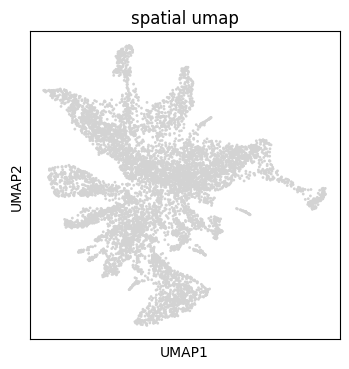

In [17]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(sct_ad_sp, title=["spatial umap"],wspace=0.4,
           show=True)

In [18]:
sc.tl.leiden(sct_ad_sp, resolution=0.3,key_added="leiden0.3")
sc.tl.leiden(sct_ad_sp, resolution=0.4,key_added="leiden0.4")
sc.tl.leiden(sct_ad_sp, resolution=0.5,key_added="leiden0.5")
sc.tl.leiden(sct_ad_sp, resolution=0.6,key_added="leiden0.6")
sc.tl.leiden(sct_ad_sp, resolution=0.7,key_added="leiden0.7")
sc.tl.leiden(sct_ad_sp, resolution=0.8,key_added="leiden0.8")

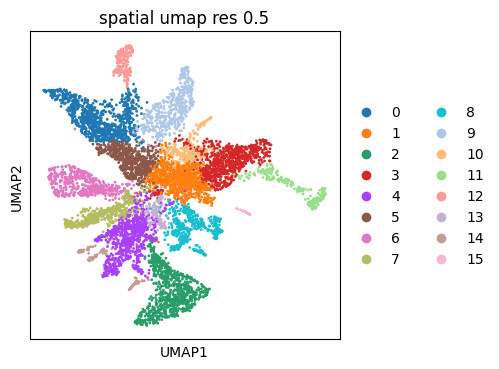

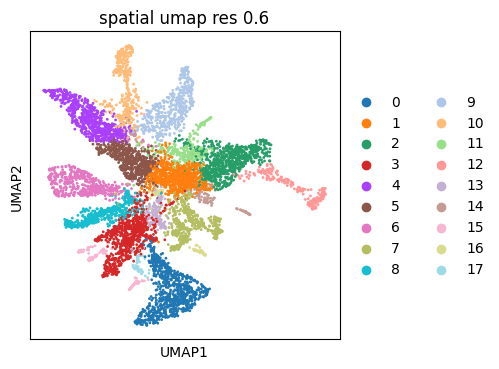

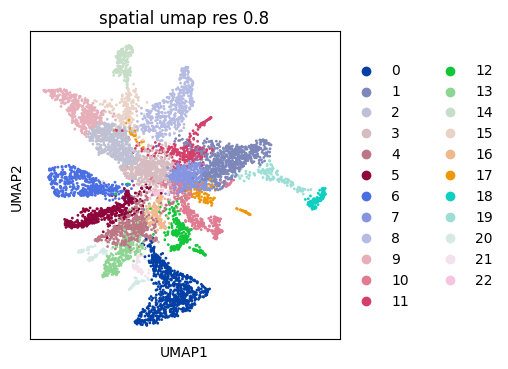

In [19]:
sc.pl.umap(sct_ad_sp, color=["leiden0.5"], title=["spatial umap res 0.5"],wspace=0.4,
           show=True, save='_spatial_leiden_louvain.png')

sc.pl.umap(sct_ad_sp, color=["leiden0.6"], title=["spatial umap res 0.6"],wspace=0.4,
           show=True, save='_spatial_leiden_louvain.png')

sc.pl.umap(sct_ad_sp, color=["leiden0.8"], title=["spatial umap res 0.8"],wspace=0.4,
           show=True, save='_spatial_leiden_louvain.png')

In [20]:
sct_ad_sp.write_h5ad(spdatapath+'sct_spatial.h5ad')